In [5]:
#install kaggle library
! pip install kaggle

In [6]:
#configure the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

 96% 78.0M/80.9M [00:00<00:00, 136MB/s]
100% 80.9M/80.9M [00:00<00:00, 114MB/s]


In [8]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
#printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# loading the data from csv file to pandas dataframe
twitter_data = pd.read_csv('//content/training.1600000.processed.noemoticon.csv', encoding='iSO-8859-1')

In [16]:
# CHECKING THE NUMBER OF ROWS AND COLUMNS
twitter_data.shape

(1599999, 6)

In [17]:
# printning first 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [18]:
#naming the columns and reading the dataset again

column_names = ['target', 'id','date','flag','user','text']
twitter_data = pd.read_csv('//content/training.1600000.processed.noemoticon.csv', names=column_names, encoding='iSO-8859-1')

In [19]:
# CHECKING THE NUMBER OF ROWS AND COLUMNS
twitter_data.shape

(1600000, 6)

In [20]:
# printning first 5 rows of the dataframe
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [21]:
# counting missing values in dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [22]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [23]:
twitter_data.replace({'target':{4:1}}, inplace =True)

In [24]:
port_steam = PorterStemmer()

In [25]:
def stemming(content):
    stemmer = nltk.SnowballStemmer('english')
    stemmed_content = content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [26]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming) #50 min to wait for this execution

In [27]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset can't updat facebook text it... might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dive mani time ball. manag save 50% ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, behav all. i'm mad. here?..."


In [28]:
print(twitter_data['stemmed_content'])

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          upset can't updat facebook text it... might cr...
2          @kenichan dive mani time ball. manag save 50% ...
3                            whole bodi feel itchi like fire
4          @nationwideclass no, behav all. i'm mad. here?...
                                 ...                        
1599995                       woke up. school best feel ever
1599996    thewdb.com - cool hear old walt interviews! â...
1599997                      readi mojo makeover? ask detail
1599998    happi 38th birthday boo alll time!!! tupac ama...
1599999    happi #charitytuesday @thenspcc @sparkschar @s...
Name: stemmed_content, Length: 1600000, dtype: object


In [29]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [30]:
# separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [31]:
print(X)

['@switchfoot http://twitpic.com/2y1zl - awww, that bummer. shoulda got david carr third day it. ;d'
 "upset can't updat facebook text it... might cri result school today also. blah!"
 '@kenichan dive mani time ball. manag save 50% rest go bound' ...
 'readi mojo makeover? ask detail'
 'happi 38th birthday boo alll time!!! tupac amaru shakur'
 'happi #charitytuesday @thenspcc @sparkschar @speakinguph4h']


In [32]:
print(Y)

[0 0 0 ... 1 1 1]


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [34]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [35]:
print(X_train)

['watch saw iv drink lil wine' "@hatermagazin i'm in!"
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 "hope everyon mother great day! can't wait hear guy store tomorrow!"
 'love wake folgers. bad voic deeper his.']


In [36]:
print(Y_test)

[0 1 0 ... 1 0 1]


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
print(type(X_train))

<class 'numpy.ndarray'>


In [39]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [40]:
print(X_train)

  (0, 555056)	0.44872071677182435
  (0, 311521)	0.42139878820156595
  (0, 166661)	0.3784258390024876
  (0, 253881)	0.5248770996321014
  (0, 452408)	0.3579598085710012
  (0, 547836)	0.2724618684273102
  (1, 246930)	0.4216748669629444
  (1, 225963)	0.9067471017719236
  (2, 374825)	0.1668935707272662
  (2, 193530)	0.20185026966419675
  (2, 214505)	0.18696806053652665
  (2, 245500)	0.1610871849298624
  (2, 515944)	0.15260651817586954
  (2, 348922)	0.24083670228348006
  (2, 555463)	0.33615513831638094
  (2, 129186)	0.31180310787000864
  (2, 544237)	0.32797662458056626
  (2, 512826)	0.3201678621219188
  (2, 190292)	0.291960339536279
  (2, 513806)	0.1860264155402729
  (2, 184225)	0.19027374838761577
  (2, 166661)	0.46136477277006543
  (3, 239237)	0.38347641261447546
  (3, 518639)	0.2688968511993747
  (3, 492216)	0.39148958119338084
  :	:
  (1279996, 409476)	0.21030232633902124
  (1279996, 314914)	0.22194518109414565
  (1279996, 377841)	0.17758989770758854
  (1279996, 519819)	0.186817733790113

In [41]:
print(X_test)

  (0, 529807)	0.17900942398484318
  (0, 515944)	0.3153930138698844
  (0, 504440)	0.3462299430969367
  (0, 491887)	0.2185991831237322
  (0, 363551)	0.17675365880596933
  (0, 354010)	0.4498316803743235
  (0, 238036)	0.28474121530713686
  (0, 200309)	0.23615264324054905
  (0, 193590)	0.25349565014652997
  (0, 162862)	0.37376133709318926
  (0, 117417)	0.26713376582199133
  (0, 74693)	0.16118353415737766
  (0, 55670)	0.17055177254735585
  (1, 465891)	0.24406908706556932
  (1, 444653)	0.48181114184031076
  (1, 337340)	0.2840519213750515
  (1, 291211)	0.406790936717856
  (1, 208617)	0.5713191695769567
  (1, 55670)	0.20818991919184796
  (1, 45681)	0.30393306520623053
  (2, 506399)	0.43371023675769377
  (2, 337430)	0.2586748312006373
  (2, 251871)	0.5874342825133929
  (2, 143581)	0.36246174089605776
  (2, 78463)	0.3787496131633456
  :	:
  (319995, 525954)	0.39960532868462395
  (319995, 416847)	0.33556091868419075
  (319995, 406560)	0.25817748380750044
  (319995, 384272)	0.4023349514876709
  (31

In [42]:
model = LogisticRegression(max_iter=1000)

In [43]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [44]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [45]:
print('Accuracy score on the training data :', training_data_accuracy)

Accuracy score on the training data : 0.816740625


In [46]:
# accuracy score on the testing data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [47]:
print('Accuracy score on the testing data :', test_data_accuracy)

Accuracy score on the testing data : 0.782275


In [48]:
import pickle

In [49]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [50]:
# loading the saved model
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [51]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')

1
[1]
Positive Tweet


In [52]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')

0
[0]
Negative Tweet


In [53]:
X_new = X_test[45]
print(Y_test[45])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')

0
[0]
Negative Tweet


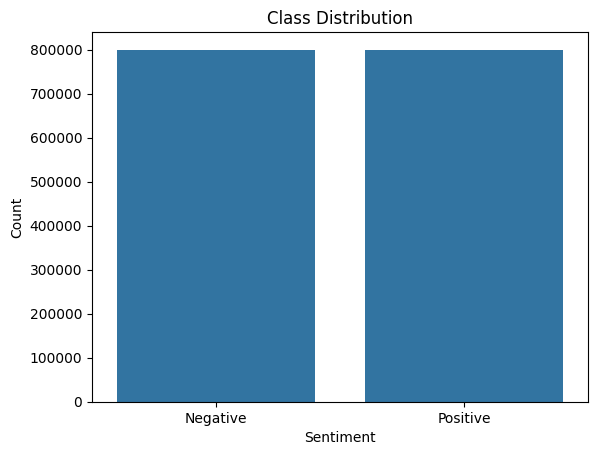

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Visualizing class distribution
sns.countplot(x='target', data=twitter_data)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


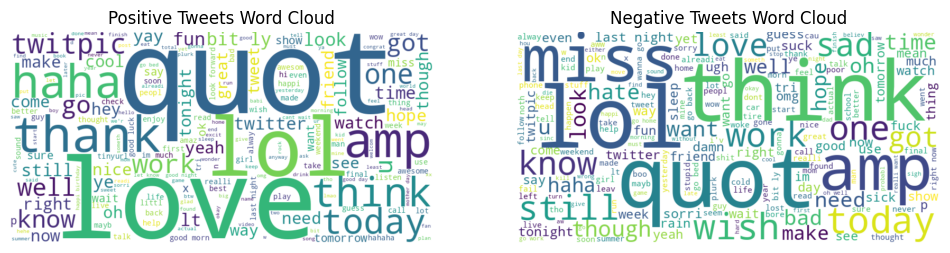

In [58]:
# Creating word clouds for positive and negative tweets
from wordcloud import WordCloud

positive_tweets = ' '.join(twitter_data[twitter_data['target'] == 1]['stemmed_content'])
negative_tweets = ' '.join(twitter_data[twitter_data['target'] == 0]['stemmed_content'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis('off')

plt.show()

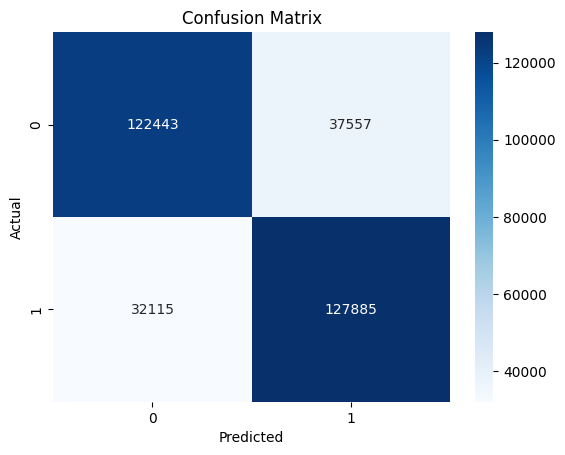

In [59]:
# Confusion matrix
cm = confusion_matrix(Y_test, X_test_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

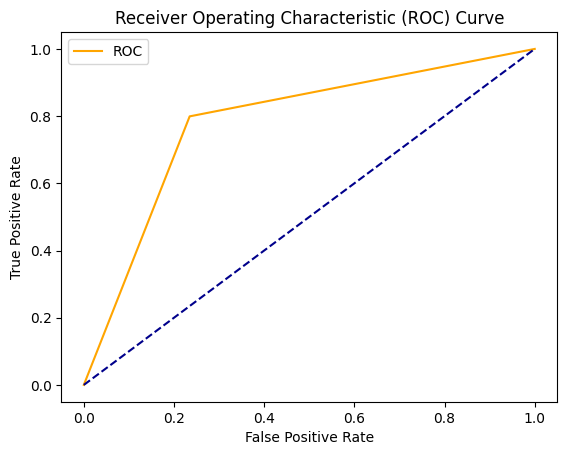

In [60]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, X_test_prediction)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

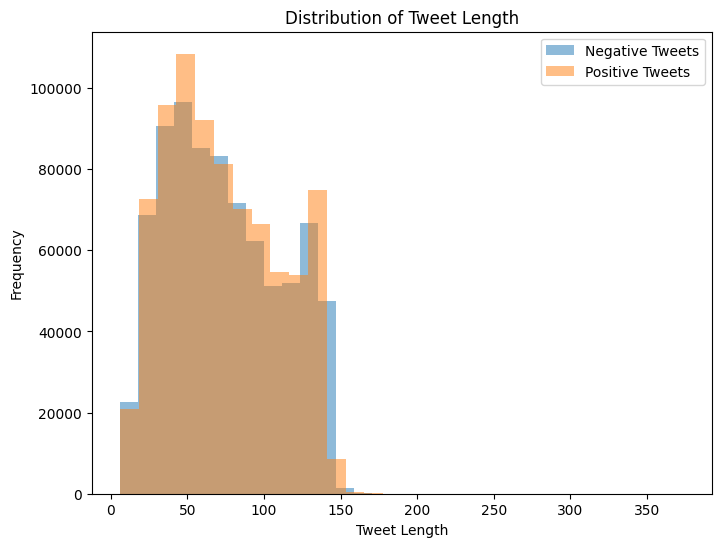

In [64]:
# Calculate tweet lengths
twitter_data['tweet_length'] = twitter_data['text'].apply(lambda x: len(x))

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(twitter_data[twitter_data['target'] == 0]['tweet_length'], bins=30, alpha=0.5, label='Negative Tweets')
plt.hist(twitter_data[twitter_data['target'] == 1]['tweet_length'], bins=30, alpha=0.5, label='Positive Tweets')
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


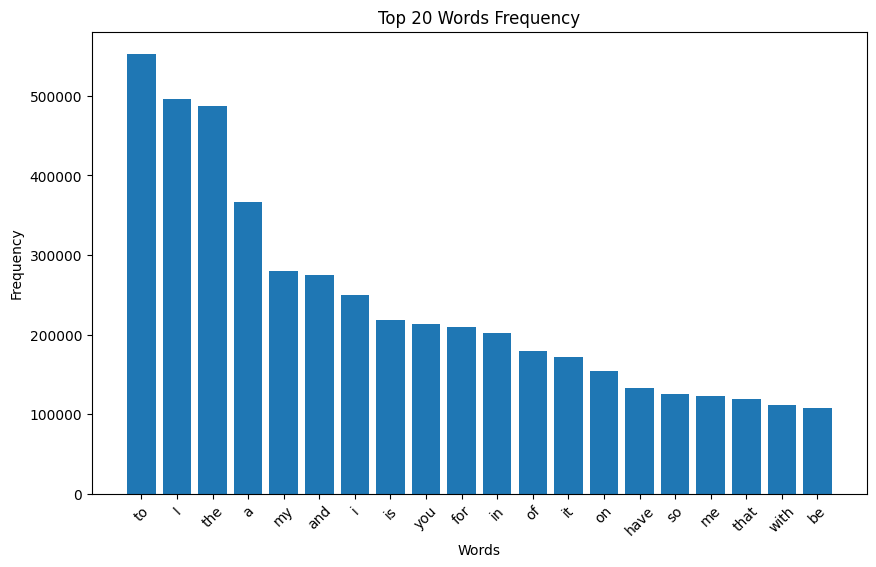

In [62]:
from collections import Counter

# Tokenize and count words
all_words = ' '.join(twitter_data['text']).split()
word_freq = Counter(all_words)

# Plot top N words
top_n = 20
top_words = dict(word_freq.most_common(top_n))

plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.title('Top {} Words Frequency'.format(top_n))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


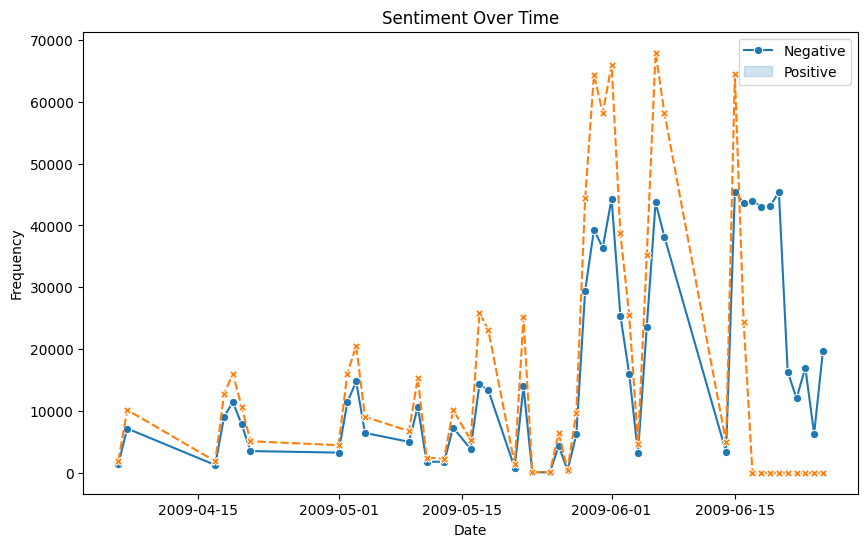

In [63]:
# Convert date column to datetime
twitter_data['date'] = pd.to_datetime(twitter_data['date'])

# Group by date and sentiment
sentiment_over_time = twitter_data.groupby([twitter_data['date'].dt.date, 'target']).size().unstack().fillna(0)

# Plot sentiment over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=sentiment_over_time, markers=True)
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(['Negative', 'Positive'])
plt.show()
